## Intersubject correlation (ISC) correlates between brains of different participants to capture shared activity

The BOLD signal contains noise. Here, we calculate correlations between subjects to reduce noise and estimate task-relevant signals. Want to find brain regions where the same levels of activity are displayed. Key predictions are that, in the theory encoding region, the ISC should:

1. Be highest for same levels, medium for same games, and lowest for random (shuffled) games
2. Increase over levels of the same game

---

> **Remark.** In this notebook we do an ISC analysis for each voxel time series. In the notebook [ISC_nosmooth](https://github.com/tomov/VGDL-fMRI-Python-Data-Analysis/blob/master/Multivariate_analyses/ISC_nosmooth.ipynb) we correlate between the rows instead (game blocks/levels). A method similar to the analysis performed in (Chen et al., 2016)

---

# ISC analysis smooth betas

- In this notebook we focus on ISC with time series. We set `pairwise=False`. See the [brainiaik isc method docs](https://brainiak.org/docs/brainiak.html?highlight=isc#brainiak.isc.isc).
- ISC is done *for every voxel* in the brain to the matching voxels in other brains, so it produces a full brain map. (In practice, to simplify the computation and the interpretation it is typical for ISC to compare each individual participant with the average of all other participants)

<img src="http://drive.google.com/uc?export=view&id=11pOdREA7eSauMymUWKCOAXelrYPRuYHF" style="height:250px"/>


### 3.1 Compute ISC and create statistical map

- We massage the data into `[TRs, voxels, subjects]` so that we can do the ISC with brainiak. This outputs `[subjects, voxels]`. How to interpret/visualise this?
- First we load in an anatomical image`.nii` underlay. We use the modules `nibabel` and `nilearn` to work with this kind of data. [more info](https://nipy.org/nibabel/coordinate_systems.html) and [docs](https://nipy.org/nibabel/reference/nibabel.nifti1.html?highlight=nifti1image#nibabel.nifti1.Nifti1Image)
    - after loading in a `.nii` file with `nibabel` the shape is 3D; `(x,y,z)`, these are voxel arrays.
    - e.g. the values (26, 30, 16) are indices into the data array. (26, 30, 16) is therefore a ‘voxel coordinate’. These voxel coordinates are defined in a reference space called voxel space. 
    - **the affine matrix can transform coordinates between references spaces** (affine array tells the position of the image array in a reference space)
    - **RAS+** are the default output coordinates but there are other reference spaces are such as *Talairach atlas brain*
 
    
e.g. We have voxel coordinates (in voxel space). We want to get scanner RAS+ coordinates corresponding to the voxel coordinates. We need a coordinate transform to take us from voxel coordinates to scanner RAS+ coordinates. In general, we have some voxel space coordinate (i,j,k), and we want to generate the reference space coordinate (x,y,z).

- Next, we make a **statistical map** in the following manner (this plots the t-statistics)

<img src="http://drive.google.com/uc?export=view&id=1vdXirMgrYoxeekbc0UoEfBYLv6K8B4aq" style="height:220px"/>


### Compute averages across subjects

- We collapse the ISC maps by setting `summary_statistic` to `'mean'` or `'median'`. This returns `[n_voxels, 1]`.

> **How `brainiak.isc` collapses the correlation values to an average.**

>    When you set `compute_summary='mean'` brainiak uses the [compute_summary_statistic](https://brainiak.org/docs/brainiak.html#brainiak.isc.compute_summary_statistic) to compute an average for each voxel across participants.

```Python
# Summarize results (if requested)
    if summary_statistic:
        iscs = compute_summary_statistic(iscs,
                                         summary_statistic=summary_statistic,
                                         axis=0)[np.newaxis, :]
```

> 1) ISC values are first Fisher Z transformed (arctanh); 2) Average the mean values; 3) Apply the inverse Fisher transform to get the correlation values back (tanh). 

`Computes either the ‘mean’ or ‘median’ across a set of ISCs. In the case of the mean, ISC values are first Fisher Z transformed (arctanh), averaged, then inverse Fisher Z transformed (tanh).`

### 3.2 Visualise Averaged ISC map

- After that, use this vector with average correlation values to plot the t-statistics with `plot_stat_map`, with a certain threshold. This method plots the t-values.

> `plot_stat_map`: Plotting a statistical map, like a T-map, a Z-map, or an ICA, with an optional background [more info](https://nilearn.github.io/plotting/index.html#different-plotting-functions)

- We collapse the ISC maps by setting `summary_statistic` to 'mean' or 'median'. This returns `[n_voxels, 1]`.

### 3.3 Visualise Averaged ISC map using a surface plot

- surface plots are diagrams of 3D data
- show a functional relationship between a designated dependent variable (Y), and two independent variables
(X and Z). The plot is a companion plot to the contour plot. [nilearn docs](https://nilearn.github.io/modules/generated/nilearn.plotting.plot_surf_stat_map.html)

### 3.4 Visualise averages ISC map using glass brain plot

> `plot_glass_brain.` Glass brain visualization. By default plots maximum intensity projection of the absolute values. To plot positive and negative values set plot_abs parameter to False.

---

# Outline

### 1. ISC with Blocks (`glm1`)

### 2. ISC with Games 

### 3. ISC with Levels (`glm25`)

### 4. ISC with Boxcars (`glm24`)

In [315]:
import h5py
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import os 
import glob
import time
from copy import deepcopy
import numpy as np
import pandas as pd 

from nilearn import datasets, image
from nilearn import surface
from nilearn import plotting
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
import nibabel as nib

from brainiak import image, io
from brainiak.isc import isc, isfc, permutation_isc
from brainiak.isc import compute_summary_statistic
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d 
import seaborn as sns 
import pandas as pd
from importlib import reload 
import scipy.io as sio

# import own functions
import utils
reload(utils)
from utils import decode_variable, get_in_shape_levels, get_in_shape_blocks, plot_sub_isc_statmap, plot_statmap_onesub
from utils import plot_statmap_avg, surface_plot_avg

%autosave 30
%matplotlib inline
sns.set(style = 'white', context='talk', font_scale=1, rc={"lines.linewidth": 2})

Autosaving every 30 seconds


We saved the data as `.npy` files

- `bold_data_[...]`: these files are the processed and reordered betas. This data is in the right shape to perform the ISC analysis with brainiak.
- `collapsed_corrs[...]`: these files are the collapses correlations and can be used for plotting

In [289]:
# specify local path
path = '/Users/Daphne/Desktop/data/'

# parameters
num_subjects = 8

# load all bold data
games_betas = np.load(path+'bold_data_games.npy')
blocks_betas = np.load(path+'bold_data_blocks.npy')
levels_betas = np.load(path+'bold_data_levels.npy')
# boxcar_betas = np.load(path+'bold_data_boxcar.npy')

# load all correlations
col_corrs_games = np.load(path+'collapsed_corrs_games.npy')
col_corrs_blocks = np.load(path+'collapsed_corrs_blocks.npy')
col_corrs_levels = np.load(path+'collapsed_corrs_levels.npy')
# col_corrs_boxcars = np.load(path+'collapsed_corrs_blocks.npy')

# load mask and get voxel coordinates
mask_arr = np.load(path+'mask_arr.npy') # all masks are the same
coords = np.where(mask_arr[0] == 1) # so need one set of voxel coordinates for all
# load in the nift data using nibabel module
brain_nii = nib.load(os.path.join(path, 'smoothmask.nii')) # we use the smoothmask

## Use the affine matrix to transform the voxel coordinates into MNI space

<font color=red>TODO: the voxels should line up perfectly with the brain so there shouldn't be any activity outside of the brain!! Proposed sanity test:

- Display the whole mask and see whether it lines up perfectly with the brain (plot x% of the voxels). 
- use this data for the avg plots as well as the surface plots.
- Use affine matrix to transform voxel coordinates to MNI space (e.g. by doing the below for all coordinates)

</font>

[about coordinate spaces](https://nipy.org/nibabel/coordinate_systems.html#the-affine-matrix-as-a-transformation-between-spaces)

We have voxel coordinates (in voxel space). We want to get scanner RAS+/MNI coordinates corresponding to the voxel coordinates. We need a coordinate transform to take us from voxel coordinates to scanner RAS+ coordinates.

Imagine we had solved this, and we had a coordinate transform function f that accepts a voxel coordinate and returns a coordinate in the reference space:

---

or use the function [coord transform](https://nilearn.github.io/modules/generated/nilearn.image.coord_transform.html#examples-using-nilearn-image-coord-transform)

In [232]:
from nilearn import datasets, image

??image.coord_transform

In [233]:
brain_nii.shape

(79, 95, 79)

In [234]:
5,5,5 

(5, 5, 5)

In [235]:
# get the voxel space coordinates
coords = np.array(np.where(whole_brain_mask == 1))
x_arr = [] # MNI space axes
y_arr = []
z_arr = []

# for each coordinate i,j,k 
# transform that coordinate to mni space
# store in new array

num_coords = len(coords[0])

for c in range(num_coords):

    i = coords[0][c]
    j = coords[1][c]
    k = coords[2][c]
    # Find the MNI coordinates of the voxel (i,j,k)
    x,y,z = image.coord_transform(i, j, k, brain_nii.affine)
    
    # store the MNI coordinates in the same format 
    x_arr.append(int(x))
    y_arr.append(int(y))
    z_arr.append(int(z))  

In [282]:
# put the MNI coordinates together
MNI_coords = np.array([x_arr,y_arr,z_arr])  

tuple(MNI_coords) # new coordinates

(array([ 78,  78,  78, ..., -76, -76, -76]),
 array([-60, -60, -58, ...,  -8,  -8,  -8]),
 array([ 8, 10,  2, ..., -2,  0, 18]))

In [283]:
MNI_coords[0].shape

(220075,)

In [238]:
coords

array([[ 0,  0,  0, ..., 77, 77, 77],
       [26, 26, 27, ..., 52, 52, 52],
       [39, 40, 36, ..., 34, 35, 44]])

In [239]:
#image.coord_transform(50, 50, 50, brain_nii.affine)

In [240]:
# we have our nifti image
brain_nii.affine # the affine matrix tells us the position of the image array in reference space

array([[  -2.,    0.,    0.,   78.],
       [   0.,    2.,    0., -112.],
       [   0.,    0.,    2.,  -70.],
       [   0.,    0.,    0.,    1.]])

## Check data shapes

In [241]:
for i in mask_arr:
    print(i.shape)
    
print(mask_arr.shape) # [subjects, (mask)]

(79, 95, 79)
(79, 95, 79)
(79, 95, 79)
(79, 95, 79)
(79, 95, 79)
(79, 95, 79)
(79, 95, 79)
(79, 95, 79)
(8, 79, 95, 79)


In [242]:
# check if all masks are indeed the same
len(np.unique(mask_arr, axis=0)) 
# this confirms it, all masks are the same, so we should we able to use any given mask to plot

1

In [243]:
games_betas.shape

(6, 220075, 8)

In [244]:
blocks_betas.shape

(18, 220075, 8)

In [245]:
levels_betas.shape

(54, 220076, 8)

In [246]:
col_corrs_games.shape # check if shapes are correct

(220075,)

In [247]:
col_corrs_blocks.shape

(220075,)

In [248]:
col_corrs_levels.shape

(220076,)

<font color=red>TODO: PROBLEM: there is def an alignment issue that needs to be solved. The voxels should line up perfectly with the brain so there shouldn't be any activity outside of the brain!! Proposed sanity test:

- Display the whole mask and see whether it lines up perfectly with the brain (plot x% of the voxels). 
- use this data for the avg plots as well as the surface plots.

</font>

> `plot_stat_map()`

```
stat_map_img: Niiimg-like object. This is the statistical map image


bg_img : Niimg-like object
            See http://nilearn.github.io/manipulating_images/input_output.html
            The background image that the ROI/mask will be plotted on top of.
            If nothing is specified, the MNI152 template will be used.
            To turn off background image, just pass "bg_img=None".

cut_coords : None, a tuple of floats, or an integer
            The MNI coordinates of the point where the cut is performed
            If display_mode is 'ortho' or 'tiled',
            this should be a 3-tuple: (x, y, z)
            
display_mode : {'ortho', 'tiled', 'x', 'y', 'z', 'yx', 'xz', 'yz'}
            Choose the direction of the cuts: 'x' - sagittal, 'y' - coronal,
            'z' - axial, 'ortho' - three cuts are performed in orthogonal
            directions, 'tiled' - three cuts are performed
            and arranged in a 2x2 grid.
            
vmax : float
            Upper bound for plotting, passed to matplotlib.pyplot.imshow
            
For visualization, non-finite values found in passed 'stat_map_img' or 'bg_img' are set to zero.
```

# 1. Games

In [249]:
games_betas.shape # [games, voxels, subjects]

(6, 220075, 8)

In [250]:
whole_brain_mask = mask_arr[0] # pick any one from the array

# compute the average across participants 
avg_isc_corrs_games = isc(games_betas, pairwise=False, summary_statistic='mean', tolerate_nans=True) 

# use the mask to find all the coordinates that represent the brain
coords = np.where(whole_brain_mask == 1) 

# Make zeros 3D cube
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for a subject into brain space
isc_vol[coords] = avg_isc_corrs_games

In [251]:
# make a nifti image with the whole brain mask (testing)
whole_brain_mask_nifti = nib.Nifti1Image(whole_brain_mask, brain_nii.affine, brain_nii.header)

# map collapsed r values onto brain
avg_isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header) 

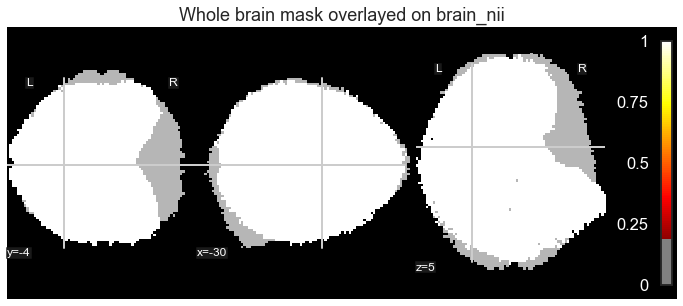

In [252]:
# plot the data as statmap
f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    stat_map_img=whole_brain_mask_nifti, 
    bg_img=brain_nii,
    threshold=0.2, 
    axes=ax,
    cut_coords=[-30, -4, 5]
)
ax.set_title(f'Whole brain mask overlayed on brain_nii'); # now the alignment issue is clearly visible

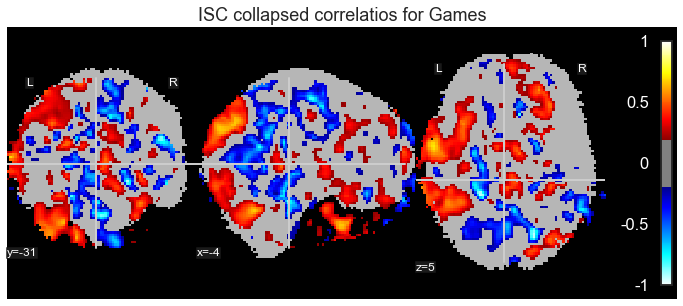

In [253]:
# plot the data as statmap
f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_stat_map(
    stat_map_img=avg_isc_nifti, 
    bg_img=brain_nii,
    threshold=0.2, 
    axes=ax,
    black_bg=True,
    vmax=1,
)
ax.set_title(f'ISC collapsed correlatios for Games'); # now the alignment issue is clearly visible

## Use MNI coords to plot the statistical map

In [212]:
MNI_coords.shape

(3, 220075)

In [213]:
coords.shape

(3, 220075)

In [254]:
# compute the average across participants 
avg_isc_corrs_games = isc(games_betas, pairwise=False, summary_statistic='mean', tolerate_nans=True) 

# use the MNI_coords

In [259]:
max(MNI_coords[0])

78

In [256]:
# Make zeros 3D cube 
isc_vol = np.zeros(brain_nii.shape) # have to come up with a different way make the zeros volume

isc_vol[tuple(MNI_coords)] = avg_isc_corrs_games

IndexError: index -96 is out of bounds for axis 1 with size 95

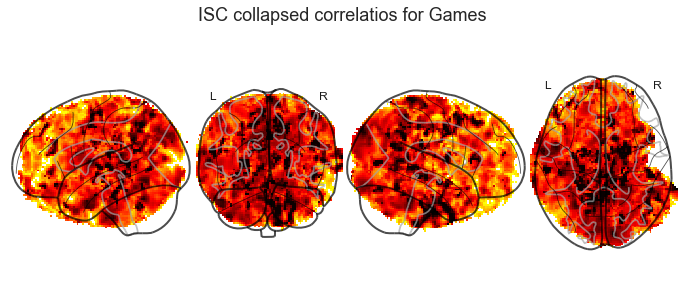

In [106]:
f, ax = plt.subplots(1,1, figsize = (12, 5))
plotting.plot_glass_brain(
    stat_map_img=avg_isc_nifti, 
    display_mode='lyrz',
    axes=ax,
)
ax.set_title(f'ISC collapsed correlatios for Games'); # now the alignment issue is clearly visible

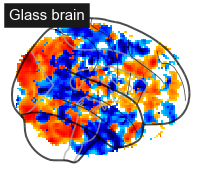

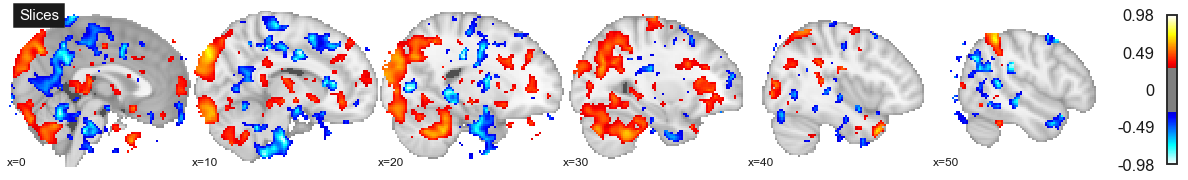

In [115]:
plotting.plot_glass_brain(stat_map_img=avg_isc_nifti, display_mode='r', plot_abs=False,
                          title='Glass brain', threshold=0.3)

plotting.plot_stat_map(stat_map_img=avg_isc_nifti, display_mode='x',
                       cut_coords=range(0, 51, 10), title='Slices', threshold=0.3)

In [89]:
??plotting.plot_stat_map

## 1.1 ISC per subject

In [48]:
# for i in range(num_subjects):
#     plot_sub_isc_statmap(sub=i, data=games_betas, brain_nii=brain_nii, mask_data=mask_arr, threshold =.2,)

## 1.2 Collapse ISC correlations

## 1.3 Statistical maps

## 1.4 Surface plots

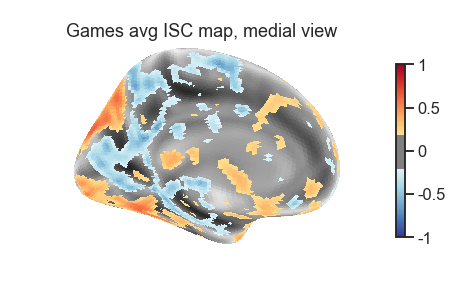

In [269]:
from nilearn import datasets

threshold = .2 
view_medial = 'medial'
view_lateral = 'lateral'

# get a surface
fsaverage = datasets.fetch_surf_fsaverage5()

# Make the ISC output a volume
isc_vol = np.zeros(brain_nii.shape)
# Map the ISC data for the first participant into brain space
isc_vol[coords] = avg_isc_corrs_games
# make a nii image of the isc map 
isc_nifti = nib.Nifti1Image(isc_vol, brain_nii.affine, brain_nii.header)
# make "texture" 
texture = surface.vol_to_surf(isc_nifti, fsaverage.pial_left) 

# plot 
title_text = ('Games avg ISC map, medial view')
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture, 
    hemi='left', view=view_medial, 
    title= title_text, 
    threshold=threshold, cmap='RdYlBu_r', 
    colorbar=True,
    bg_map=fsaverage.sulc_left,
    vmax=1)

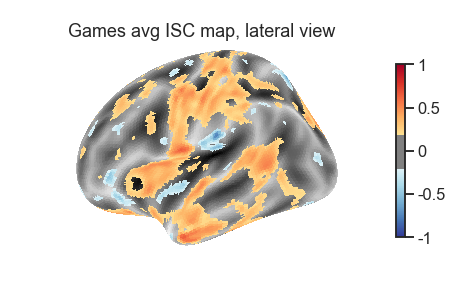

In [270]:
title_text = ('Games avg ISC map, lateral view')
surf_map = plotting.plot_surf_stat_map(
    fsaverage.infl_left, texture, 
    hemi='left', view=view_lateral, 
    title= title_text, 
    threshold=threshold, cmap='RdYlBu_r', 
    colorbar=True,
    bg_map=fsaverage.sulc_left,
    vmax=1)

# 2. Blocks

In [285]:
blocks_betas.shape # [TRs, voxels, subjects]

(18, 220075, 8)

In [286]:
# make isc_maps
# got coordinates (coords)

# compute the isc correlations using the leave one out approach
isc_maps_blocks = isc(blocks_betas, pairwise=False)

isc_maps_blocks.shape

(8, 220075)

In [291]:
# Make zeros 3D cube
isc_vol = np.zeros(brain_nii.shape)

## 2.1 ISC per subject statmap

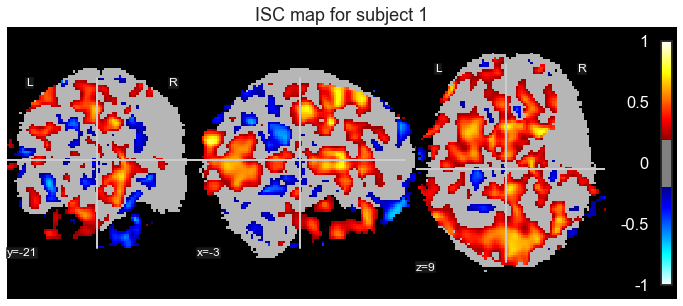

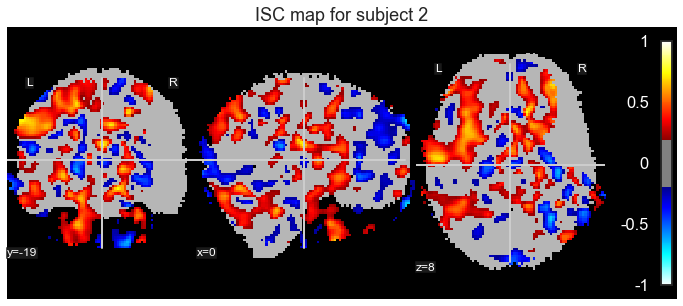

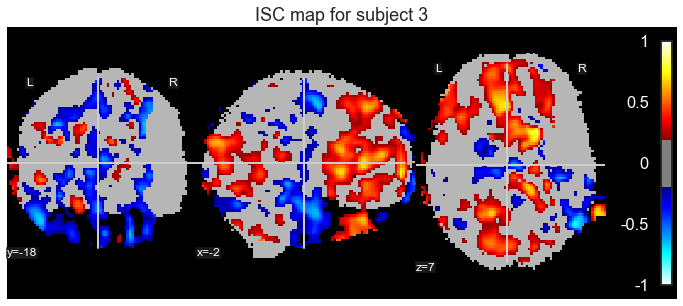

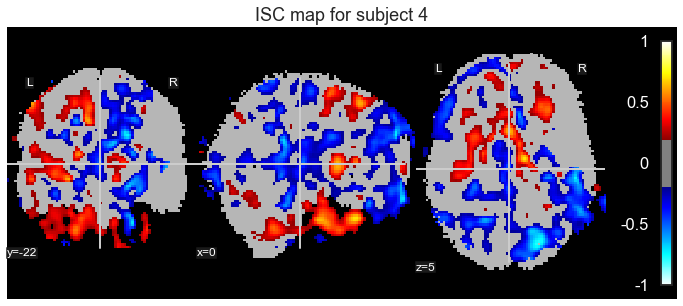

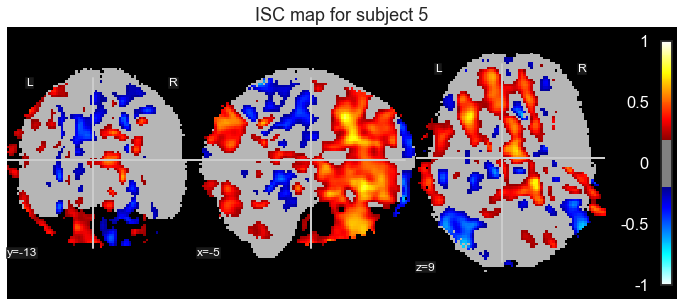

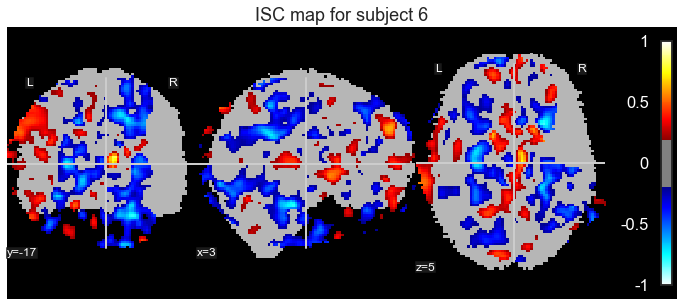

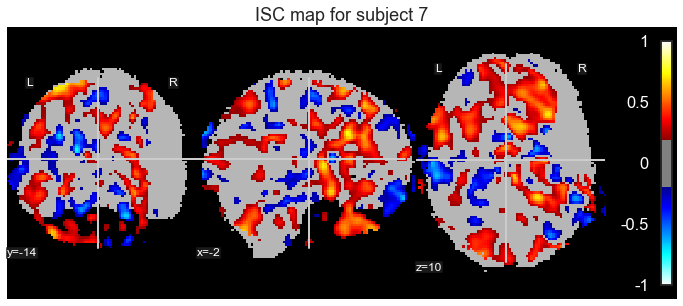

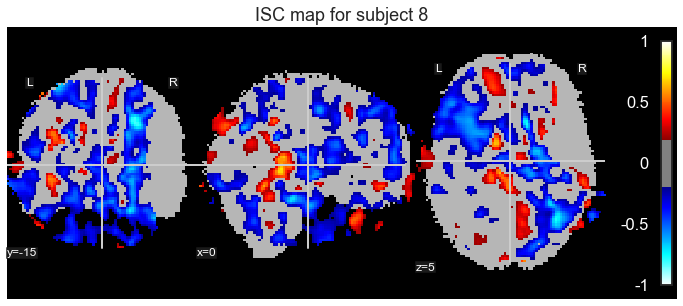

In [294]:
for i in range(num_subjects):
    plot_statmap_onesub(sub=i, isc_vol=isc_vol, isc_maps=isc_maps_blocks, coords=coords, brain_nii=brain_nii, threshold=0.2, use_brainii=True)

## 2.2 ISC average statmap

In [301]:
# compute the average across participants 
avg_isc_corrs_blocks = isc(blocks_betas, pairwise=False, summary_statistic='mean', tolerate_nans=True) 

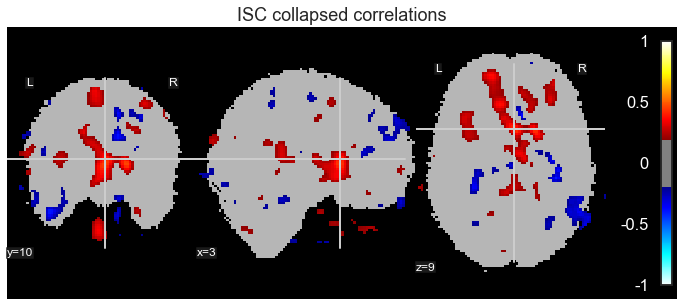

In [305]:
plot_statmap_avg(isc_vol=isc_vol, coords=coords, collapsed_isc_corrs=avg_isc_corrs_blocks, brain_nii=brain_nii, use_brainii=True, threshold=0.2)

## 2.3 ISC average surface plot

In [317]:
reload(utils)
from utils import surface_plot_avg

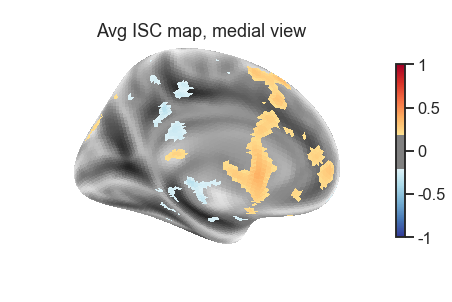

In [318]:
surface_plot_avg(isc_vol=isc_vol, coords=coords, brain_nii=brain_nii, collapsed_isc_corrs=avg_isc_corrs_blocks, view='medial', threshold=0.2, )

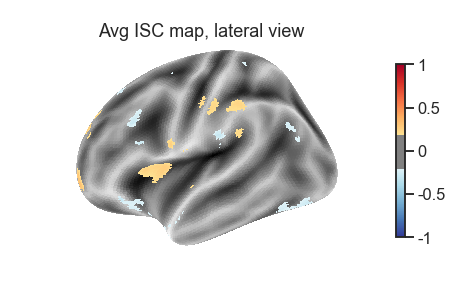

In [319]:
surface_plot_avg(isc_vol=isc_vol, coords=coords, brain_nii=brain_nii, collapsed_isc_corrs=avg_isc_corrs_blocks, view='lateral', threshold=0.2)

# 3. Levels

# 4. Boxcars